# Movie Recommender Systems

## Overview

The rapid growth of data collection has led to a new era of information. Data is being used to create more efficient systems and this is where Recommendation Systems come into play. Recommendation Systems are a type of information filtering systems as they improve the quality of search results and provides items that are more relevant to the search item or are realted to the search history of the user.

In this notebook, I'm using the data provided by MovieLens and it contains various information in serveral datasets. I'm going to be using three datasets: ratings, movies and users which contain the following columns:
- UserId : the id of the person who gave the rating
- MovieId : the number of identification of the movie being rated
- rating : how much out of 5 did the user give
- title of the movie
- genre : contains keywords that describe the movie
- tags : which are specific phrases the users gave to describe the movie 

I'll also be using three kinds of recommender systems :
- Demographic filtering or Popularity filtering : offers generalized recommendations to every user, based on movie popularity and/or genre. The System recommends the same movies to users with similar demographic features. Since each user is different , this approach is considered to be too simple. The basic idea behind this system is that movies that are more popular and critically acclaimed will have a higher probability of being liked by the average audience.
- Content based filtering : suggests similar items based on a particular item. This system uses item metadata, such as genre, director, description, actors, etc. for movies, to make these recommendations. The general idea behind these recommender systems is that if a person liked a particular item, he or she will also like an item that is similar to it.
- Collaborative filtering : matches persons with similar interests and provides recommendations based on this matching. Collaborative filters do not require item metadata like its content-based counterparts.

## Objectives

Create 3 kinds of recommender systems based on the rating history and movie descriptions.
Make recommendations and compare them.

## Summary

- Importing libraries and datasets
- Pre_processing and dataviz
- Popularity filtering
- Content based filerting
- Collaborative filtering with SVD
- Conclusion

### Importing Libraries

In [50]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel,cosine_distances
import dask.dataframe as dd
from scipy.stats import pearsonr
from sklearn.decomposition import TruncatedSVD

### The Datasets

In [51]:
ratings = pd.read_csv(r'C:\Users\imane\OneDrive\Desktop\movie-recommendation\moiveLens\ratings.csv', sep =",")
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 762.9 MB


In [52]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [53]:
ratings.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [54]:
movies = pd.read_csv(r'C:\Users\imane\OneDrive\Desktop\movie-recommendation\moiveLens\movies.csv', sep =",")
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [55]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [56]:
movies.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

In [57]:
# Removing the time stamp
ratings = ratings.drop(["timestamp"], axis = 1)

In [58]:
# Merge the datasets on movie id
movie_ratings = movies.merge(ratings, on ="movieId")
movie_ratings.head()

,movieId,title,genres,userId,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2,3.5
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3,4.0
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4,3.0
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8,4.0


In [59]:
# Adding columns : average rating and number of ratings per movie
movie_av_ratings = movie_ratings.groupby("title")["rating"].mean().reset_index()
movie_av_ratings = movie_av_ratings.rename(columns={"rating":"average rating"})
movie_av_ratings.head()

,title,average rating
0,"""BLOW THE NIGHT!"" Let's Spend the Night Togeth...",3.000000
1,"""Great Performances"" Cats (1998)",2.896648
2,#1 Cheerleader Camp (2010),2.111111
3,#Captured (2017),3.750000
4,#Female Pleasure (2018),3.666667


In [60]:
movie_count_ratings = movie_ratings.groupby("title")["rating"].count().reset_index()
movie_count_ratings = movie_count_ratings.rename(columns={"rating": "rating count"})
movie_count_ratings.head()

,title,rating count
0,"""BLOW THE NIGHT!"" Let's Spend the Night Togeth...",1
1,"""Great Performances"" Cats (1998)",179
2,#1 Cheerleader Camp (2010),9
3,#Captured (2017),2
4,#Female Pleasure (2018),3


In [61]:
# Merging the two sets
dataset = movie_count_ratings.merge(movie_av_ratings, on = "title")
dataset.head()

,title,rating count,average rating
0,"""BLOW THE NIGHT!"" Let's Spend the Night Togeth...",1,3.000000
1,"""Great Performances"" Cats (1998)",179,2.896648
2,#1 Cheerleader Camp (2010),9,2.111111
3,#Captured (2017),2,3.750000
4,#Female Pleasure (2018),3,3.666667


### Some DataViz and pre-processing

(array([5.8204e+04, 4.7500e+02, 1.4100e+02, 6.5000e+01, 3.3000e+01,
        1.5000e+01, 1.2000e+01, 7.0000e+00, 2.0000e+00, 4.0000e+00]),
 array([1.0000e+00, 8.1500e+03, 1.6299e+04, 2.4448e+04, 3.2597e+04,
        4.0746e+04, 4.8895e+04, 5.7044e+04, 6.5193e+04, 7.3342e+04,
        8.1491e+04]),
 <BarContainer object of 10 artists>)

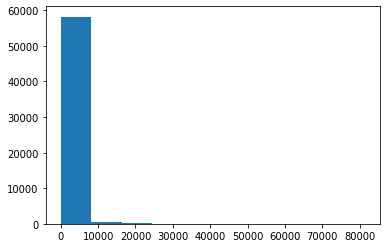

In [62]:
plt.hist(dataset["rating count"])

(array([  678.,   989.,  1871.,  4157.,  7805., 15580., 16879.,  8601.,
         1471.,   927.]),
 array([0.5 , 0.95, 1.4 , 1.85, 2.3 , 2.75, 3.2 , 3.65, 4.1 , 4.55, 5.  ]),
 <BarContainer object of 10 artists>)

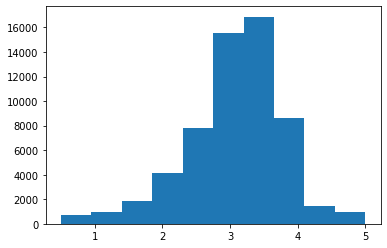

In [63]:
plt.hist(dataset["average rating"])

The hist plot suggests the existance of some outliers seen as so many movies have been rated very few times, we need to set a threshold of popularity to only take into consideration movies that have been seen and rated by many people. I decided to set the threshold at 30 meaning that if less than 30 people have rated the movie, it won't be considered by the recommender.

In [64]:
# Setting up a popularity threshold
popularity = 30
dataset = dataset[dataset["rating count"]>= popularity]
dataset.describe()

,rating count,average rating
count,15912.000000,15912.000000
mean,1555.458333,3.256978
std,4586.022847,0.480636
min,30.000000,0.854839
25%,66.000000,2.972858
50%,201.000000,3.319956
75%,909.250000,3.611803
max,81491.000000,4.483096


Now we see that the minimun value for rating count is 30, mean 50 and so on.

## Popularity filtering

Popularity filtering is based on the idea that movies that have been rated highly by a lot of people are likely to please the new person. To do this, we need to use a weighted average that enable to gauge the popularity depending on how many people rated the movie; meaning that for example a movie that has been rated 4 stars by say 100 people should be recommended more than a movie that has been rated 5 stars by only 2 people.

The formula for the weighed average is as follows:

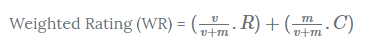
where:
- v is the number of votes for a movie, 
- m is the min votes required to be in the chart
- R is the average rating of the movie 
- C is the mean vote across the entire dataset

In [65]:
# Let's calculate C which is the average rating of all movies
C = dataset["average rating"].mean()
C

3.2569781620132923

In [66]:
# Now we need to set the value of m which is the minimum number of votes that a movie has to have to figure in the chart
# I used the 75% percentile i.e for a movie to feature in the chart it must have more votes than at least 75% of the movies
m = dataset["rating count"].quantile(0.75)
m

909.25

In [67]:
# Filter out the movies that can feature in the charts
dataset = dataset[dataset["rating count"] >= m]
dataset.shape

(3978, 3)

In [68]:
# The dataset now has only 3978 movies 
# Now we need to calculate the weighed scores of each of these movies and store it a new column
def weighted_score(x, m=m, C=C):
    v = x["rating count"]
    R = x["average rating"]
    return (v/(v+m) * R) + (m/(v+m)*C)

In [69]:
dataset["weighted score"] = dataset.apply( weighted_score, axis =1)
dataset = dataset.sort_values("weighted score", ascending = False)
dataset.head(10)

,title,rating count,average rating,weighted score
41782,"Shawshank Redemption, The (1994)",81482,4.413576,4.400812
19301,"Godfather, The (1972)",52498,4.324336,4.306165
55289,"Usual Suspects, The (1995)",55366,4.284353,4.267754
19302,"Godfather: Part II, The (1974)",34188,4.261759,4.235728
40816,Schindler's List (1993),60411,4.247579,4.232891
16751,Fight Club (1999),58773,4.228311,4.213513
38620,Rear Window (1954),20162,4.237948,4.195618
34839,One Flew Over the Cuckoo's Nest (1975),36058,4.218662,4.195008
182,12 Angry Men (1957),16569,4.243014,4.191719
41448,Seven Samurai (Shichinin no samurai) (1954),13367,4.254769,4.191220


Here we have the top 10 recommended movies. This recommendation is general and does not take into consideration the watching history of the user nor their personal preferences. 

[Text(0.5, 1.0, 'Top 10 recommended movies')]

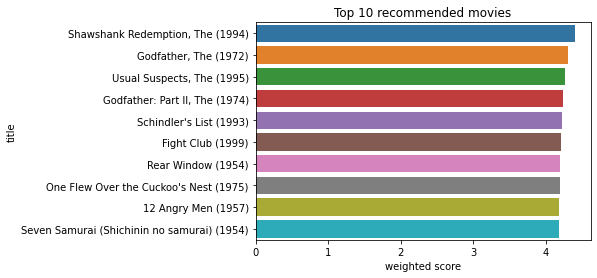

In [70]:
# Visualize the results
ds = dataset.head(10)
sns.barplot(x = "weighted score", y = "title", data = ds).set(title = "Top 10 recommended movies")

## Content based filtering

suggest similar items based on a particular item. This system uses item metadata, such as genre, director, description, actors, etc. for movies, to make recommendations. The general idea behind these recommender systems is that if a person liked a particular item, he or she will also like an item that is similar to it.

For this project I'll be using both the genre of the movie and its tag

In [71]:
# Import the tags dataset
tags = pd.read_csv(r'C:\Users\imane\OneDrive\Desktop\movie-recommendation\moiveLens\tags.csv', sep =",")
tags.head()

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


In [72]:
# Merging it with the movies dataset which contains the genres
movie_desc = tags.merge(movies, on = "movieId" )
movie_desc = movie_desc.drop("timestamp", axis =1)
movie_desc.head()

,userId,movieId,tag,title,genres
0,3,260,classic,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
1,3,260,sci-fi,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
2,110,260,action,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
3,110,260,adventure,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
4,110,260,fantasy,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi


In [73]:
movie_desc = movie_desc.dropna()
movie_desc.isnull().sum()

userId     0
movieId    0
tag        0
title      0
genres     0
dtype: int64

In [74]:
# Combining the genre and tag in one column
movie_desc["genres"] = movie_desc['tag'].astype(str) +" "+ movie_desc["genres"]
movie_desc = movie_desc.drop("tag", axis = 1)
movie_desc = movie_desc.rename(columns={"genres": "tag and genre"})
movie_desc.head()

,userId,movieId,title,tag and genre
0,3,260,Star Wars: Episode IV - A New Hope (1977),classic Action|Adventure|Sci-Fi
1,3,260,Star Wars: Episode IV - A New Hope (1977),sci-fi Action|Adventure|Sci-Fi
2,110,260,Star Wars: Episode IV - A New Hope (1977),action Action|Adventure|Sci-Fi
3,110,260,Star Wars: Episode IV - A New Hope (1977),adventure Action|Adventure|Sci-Fi
4,110,260,Star Wars: Episode IV - A New Hope (1977),fantasy Action|Adventure|Sci-Fi


In [75]:
# Removing unecessary characters
movie_desc["tag and genre"]  = movie_desc["tag and genre"].str.replace("|"," ")
movie_desc.head()

C:\Users\imane\AppData\Local\Temp/ipykernel_37116/1073841283.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  movie_desc["tag and genre"]  = movie_desc["tag and genre"].str.replace("|"," ")


,userId,movieId,title,tag and genre
0,3,260,Star Wars: Episode IV - A New Hope (1977),classic Action Adventure Sci-Fi
1,3,260,Star Wars: Episode IV - A New Hope (1977),sci-fi Action Adventure Sci-Fi
2,110,260,Star Wars: Episode IV - A New Hope (1977),action Action Adventure Sci-Fi
3,110,260,Star Wars: Episode IV - A New Hope (1977),adventure Action Adventure Sci-Fi
4,110,260,Star Wars: Episode IV - A New Hope (1977),fantasy Action Adventure Sci-Fi


In [76]:
# I notice that a lot of movie titles are rated by the same user or different users several times
# I will keep only one row per movie to make the computation easier
movie_desc = movie_desc.drop_duplicates(
  subset =['title'],
  keep = 'first')
movie_desc.head()

,userId,movieId,title,tag and genre
0,3,260,Star Wars: Episode IV - A New Hope (1977),classic Action Adventure Sci-Fi
6180,4,1732,"Big Lebowski, The (1998)",dark comedy Comedy Crime
7483,4,7569,You Only Live Twice (1967),so bad it's good Action Adventure Sci-Fi Thriller
7596,4,44665,Lucky Number Slevin (2006),unreliable narrators Crime Drama Mystery
8044,4,115569,Nightcrawler (2014),tense Crime Drama Thriller


In [77]:
movie_desc.to_csv("movie_desc.csv", index = False)

In [78]:
ds = pd.read_csv(r'C:\Users\imane\OneDrive\Desktop\movie-recommendation\moiveLens\movie_desc.csv', sep =",")

In [79]:
# I only kept this many instances because the cimputer gets stuck because the size is too big
ds = ds.iloc[:10000]
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   userId         10000 non-null  int64 
 1   movieId        10000 non-null  int64 
 2   title          10000 non-null  object
 3   tag and genre  10000 non-null  object
dtypes: int64(2), object(2)
memory usage: 312.6+ KB


Next move is to transform the text contained in tag and genre to a vector matrix using victorization. I'll be using TfidfVectorizer which determines the importance of a word. It does this by computing the relative frequency of the word in the document (term instances/total instances), and the Inverse Document Frequency which is the relative count of documents containing the term (log(number of documents/documents with term)), the result of TF * IDF is the importance of the word.

In [80]:
# Define the vectorizer and eliminate stop words
tfidf = TfidfVectorizer(stop_words='english')

In [81]:
# create the matrtix that makes every word in the tag and genre a column and takes as rows the movie indexes
matrix = tfidf.fit_transform(ds["tag and genre"])
matrix.shape

(10000, 3542)

We get a matrix with 35768 columns denoting all the words contained in the description column. Now we need to pick a distance or similarity measure to compute the similarity between the movies. I chose cosine similarity because it helps compute if two iteùs are pointing in the same direction. The equation of cosine similarity is:
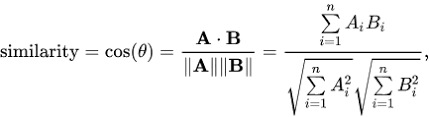
Where:
- A and B are items (movies) we want to calculate the cosine for
- A.B is the dot product of both
- |A| and |B| are the absolute values of A and B

In [82]:
# Since you get normalized vectors as a product of tfidf vectorization, we can use a linear_kernel() because it is equivalent  
# to and simpler than cosine_similarities()
cosine = linear_kernel(matrix, matrix)

In [83]:
# To identify a movie index on the dataset by its title
indices = pd.Series(ds.index, index = ds["title"])

In [84]:
# let's define the function that will return top 10 recommendations for someone who watched a perticular movie
def get_recommendations(title, cosine = cosine):
    # return the index of the movie chosen by the user
    index = indices[title]
    # return a list of the cosine score of the movie with all other movies
    cos_scores = list(enumerate(cosine[index]))
    # sort the list of scores
    cos_scores = sorted(cos_scores,  key=lambda x: x[1],reverse = True)
    # keel only the first 10 recommendations (except the first one which is the movie itself)
    cos_scores = cos_scores[1:11]
    # get the indices of teh movies on the list
    movie_ind = [i[0] for i in cos_scores]
    # return the list of movie titles
    return ds["title"].iloc[movie_ind]


In [85]:
# Try the recommender
get_recommendations("Inception (2010)")

110                    Minority Report (2002)
1648                          Oblivion (2013)
521                          Core, The (2003)
3660                     Hotel Artemis (2018)
82                    Edge of Tomorrow (2014)
559                          Star Trek (2009)
86      Dawn of the Planet of the Apes (2014)
1637                    Mortal Engines (2018)
1843                        Tykho Moon (1996)
3302                           Realive (2016)
Name: title, dtype: object

In [86]:
get_recommendations("You Only Live Twice (1967)")

6                          Fateful Findings (2013)
1871                             Mamma Mia! (2008)
1965                               Commando (1985)
3321                                 Sliver (1993)
1040             Back to the Future Part II (1989)
198          Jurassic World: Fallen Kingdom (2018)
1495    Harold and Kumar Go to White Castle (2004)
2739                          Jurassic Park (1993)
1287                             Surrogates (2009)
528                                Timeline (2003)
Name: title, dtype: object

## Collaborative filtering with SVD

makes automatic predictions (filtering) about a user's interests by collecting preferences or taste information from many users. The idea behind it is that there exist talent factors that explain the interactions between the users and movies. Such latent factor can be for example how adventurous is the movie, is it suited for children or adults, does it contain a lot of drama, etc. To do this we need to transform the data to a sparse matrix that contains the users as columns, the movies as rows and the ratings as values, then with the help of Single Value Decomposition we precise a number of latent factors that we want our model to look for, and finally we calculate the Pearson correlations based on those factors to obtain the highest correlations as the movies the user is likely to enjoy.

In [87]:
movie_ratings.head()

,movieId,title,genres,userId,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2,3.5
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3,4.0
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4,3.0
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8,4.0


In [88]:
# Drop unecessary columns
data = movie_ratings.drop(columns = ["genres","movieId"])

In [89]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25000095 entries, 0 to 25000094
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   title   object 
 1   userId  int64  
 2   rating  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 762.9+ MB


In [90]:
# Drop duplicates
data = data.drop_duplicates()

In [91]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24999761 entries, 0 to 25000094
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   title   object 
 1   userId  int64  
 2   rating  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 762.9+ MB


In [92]:
# Seen as the dataset contains more than 20 million samples, I decided to only keep million to reduce training time and cost
data = data.iloc[:1000000]

In [93]:
# Creating a pivot table that contains users as columns and movies as rows
data = data.pivot_table(index='title',columns='userId',values='rating').fillna(0)

In [94]:
data.shape

(144, 138544)

In [95]:
# Importing the single value decoposition function
SVD = TruncatedSVD(n_components=8,random_state=42)

In [96]:
X = data

In [97]:
matrix = SVD.fit_transform(X)

In [98]:
matrix.shape

(144, 8)

We see here that the single value decomposition found 8 latent value as I specified thus reducing the dimentiality of the data from 138544 columns to only 8. Next, I'll calculate the Pearson's similarity coefficient for every pair of movies in the matrix.

In [99]:
# We get a table of shape 144*144 containing correlations between all movies
corr=np.corrcoef(matrix)
corr.shape

(144, 144)

In [100]:
movie_titles = data.index

In [101]:
# Convert the index to a list of all the movies
movie_titles = movie_titles.tolist()

In [142]:
# Function that takes a title and returns a list of recommended movies
def get_rec(title, corr = corr, movie_titles = movie_titles):
    query = movie_titles.index(title)
    correlations = corr[query]
    correlations = np.round(correlations, 2)
    correlations = np.sort(correlations)
    same_movie = np.where(correlations == 1)
    correlations = np.delete(correlations, same_movie)
    indices = np.where(correlations > 0.9)[0]
    rec = []
    for i in indices:
        rec.append(movie_titles[i])
    print(rec)
         

In [143]:
get_rec('Across the Sea of Time (1995)')

['Steal Big, Steal Little (1995)', 'Sudden Death (1995)', 'Target (1995)', 'Taxi Driver (1976)', 'The Journey of August King (1995)', "Things to Do in Denver When You're Dead (1995)", 'To Die For (1995)', 'Tom and Huck (1995)', 'Toy Story (1995)', 'Twelve Monkeys (a.k.a. 12 Monkeys) (1995)', 'Two Bits (1995)', 'Two if by Sea (1996)', 'Unforgettable (1996)', 'Up Close and Personal (1996)', 'Usual Suspects, The (1995)', 'Vampire in Brooklyn (1995)', 'Waiting to Exhale (1995)', 'When Night Is Falling (1995)', 'White Balloon, The (Badkonake sefid) (1995)', 'White Squall (1996)', 'Wings of Courage (1995)']


In [144]:
get_rec('Dangerous Minds (1995)')

['Shopping (1994)', 'Silences of the Palace, The (Saimt el Qusur) (1994)', 'Sonic Outlaws (1995)', "Star Maker, The (Uomo delle stelle, L') (1995)", 'Steal Big, Steal Little (1995)', 'Sudden Death (1995)', 'Target (1995)', 'Taxi Driver (1976)', 'The Journey of August King (1995)', "Things to Do in Denver When You're Dead (1995)", 'To Die For (1995)', 'Tom and Huck (1995)', 'Toy Story (1995)', 'Twelve Monkeys (a.k.a. 12 Monkeys) (1995)', 'Two Bits (1995)', 'Two if by Sea (1996)', 'Unforgettable (1996)', 'Up Close and Personal (1996)', 'Usual Suspects, The (1995)', 'Vampire in Brooklyn (1995)', 'Waiting to Exhale (1995)', 'When Night Is Falling (1995)', 'White Balloon, The (Badkonake sefid) (1995)', 'White Squall (1996)', 'Wings of Courage (1995)']


## Conclusion

In this notebook I have taken a quick look on the data provided by MovieLens, built three base line systems for recommending movies to users. The first model was Demographic or popularity based filtering, which basically suggests the movie that were rated the highest by most people. The second model is based on the description of movie, I didn't use the plots because that contains a lot of words each and would be too costly to compute, I used the genres and tags instead and calculated the cosine similarity between the movies to finally suggest the most similar ones. And the third and final approach was collaborative filtering based on Single Value Decomposition, and suggested movie that had close by latent factors.

Finally I'd like to mention that these systems are base line and preliminary and that Hybrid Systems (that integrate more than one approach) prove more practical and come up with better recommendations.

## References

https://blog.jovian.ai/creating-a-movie-recommendation-system-using-python-5ba88a7eb6df

https://www.aurigait.com/blog/recommendation-system-using-matrix-factorization/

https://www.kaggle.com/code/ibtesama/getting-started-with-a-movie-recommendation-system?fbclid=IwAR2_4vZ1Z0kBs2K59h9h3n1lU7ftds356vfXPlX0QoIm04NBZ0JdypHgXYM

https://www.relataly.com/content-based-movie-recommender-using-python/4294/#h-implementing-a-content-based-movie-recommender-in-python